# PAM 007 #
<p>Pulse Amplitude Modulation 007, with different pulse shapes p(t) and noise added.
  Added raised cosine in frequency ('rcf'), manchester ('man'), and
  &quot;manchester sine&quot; ('msin') pulse.</p>
<p>This version uses matched filter receiver, M-ary signals, and eye diagrams.</p>  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
fsz = (7, 4)
fsz1 = (fsz[0], 1.4*fsz[1])
fsz2 = (fsz[0], fsz[1]/2.0)

In [3]:
def asc2bin(txt, bits):
    """
    ASCII character sequence to binary string conversion.
    >>>>> dn = asc2bin(txt, bits) <<<<<
    where  dn       binary output string
           txt      text input (ASCII)
           bits<0   MSB first conversion
           bits>=0  LSB first conversion
           |bits|   number of bits per character
    """
    txt_10 = list(ord(chr) for chr in txt)
    if (bits < 0):
        pow2 = list(2**(i+1) for i in range(bits,0))
    else:
        pow2 = list((2**-i) for i in range(bits))
    B = np.array(np.outer(txt_10, pow2), int)
    B = np.mod(B, 2)
    dn = np.reshape(B, -1)
    return dn

In [4]:
def bin2asc(dn, bits):
    """
    Binary string to ASCII character string conversion.
    >>>>> txt = bin2asc(dn, bits) <<<<<
    where  txt      output string (ASCII)
           dn       binary string
           bits<0   MSB first conversion
           bits>=0  LSB first conversion
           |bits|   number of bits per character
    """
    Lb = int(np.floor(len(dn)/abs(bits)))  # length in multiples of 'bits'
    dn = dn[:Lb*abs(bits)]
    B = np.reshape(dn, (-1, abs(bits)))
    if (bits < 0):
        pow2 = list(2**(i-1) for i in range(abs(bits),0,-1))
    else:
        pow2 = list(2**i for i in range(bits))
    txt_10 = np.inner(B, pow2)
    return ''.join(chr(i) for i in txt_10) 

In [5]:
def b2M(dn, m=2):
    """
    Bits to M-ary (M=2^m) symbols conversion
    >>>>> sn = b2M(dn, m) <<<<<
    """
    M = 2**m    # number of symbol values
    dL = int(m*np.ceil(len(dn)/float(m))-len(dn))
    dn = np.append(dn, np.zeros(dL))
    B = np.reshape(dn, (-1, m))
    pow2 = list(2**(i-1) for i in range(m,0,-1))
    sn = np.inner(B, pow2)
    return sn

In [6]:
def M2b(sn, m=2):
    """
    M-ary (M=2^m) symbols to binary conversion
    >>>>> dn = M2b(sn, m) <<<<<
    """
    pow2 = list(2**(i+1) for i in range(-m,0))
    B = np.array(np.outer(sn, pow2), int)
    B = np.mod(B, 2)
    sn = np.reshape(B, -1)
    return sn

In [7]:
def pam_pt(FB, Fs, ptype, pparms=[]):
    """
    Generate PAM pulse p(t)
    >>>>> ttp, pt = pam_pt(FB, Fs, ptype, pparms) <<<<<
    where  ttp:   time axis for p(t)
           pt:    PAM pulse p(t)
           FB:    Baud rate  (Fs/FB=sps)
           Fs:    sampling rate of p(t)
           ptype: pulse type from list
                  ('man', 'msin', rcf', 'rect', 'rrcf', 'sinc', 'tri')
           pparms not used for 'rect','tri'
           pparms = [k, alfa]  for 'rcf'
           pparms = [k, beta]  for 'sinc'
           k:     "tail" truncation parameter for 'sinc'
                  (truncates p(t) to -k*TB <= t < k*TB)
           beta:  Kaiser window parameter for 'sinc'
           alfa: Rolloff parameter for 'rcf', 0<=alfa<=1
    """
    ptyp = ptype.lower()
    if (ptyp=='rect' or ptyp=='man' or ptyp=='msin'):
        kR = 0.5; kL = -kR
    elif ptyp=='tri':
        kR = 1.0; kL = -kR
    elif (ptyp=='rcf' or ptyp=='rrcf' or ptyp=='sinc'):
        kR = pparms[0]; kL = -kR
    else:
        kR = 0.5; kL = -kR
    tpL, tpR = kL/float(FB), kR/float(FB)
    ixpL, ixpR = int(np.ceil(tpL*Fs)), int(np.ceil(tpR*Fs))
    ttp = np.arange(ixpL, ixpR)/float(Fs)  # time axis for p(t)
    pt = np.zeros(ttp.size)
    if ptyp=='man':
        pt = -np.ones(ttp.size)
        ixp = np.where(ttp>=0)
        pt[ixp] = 1
    elif ptyp=='msin':
        pt = np.sin(2*np.pi*FB*ttp)
    elif ptyp=='rcf':
        pt = np.sinc(FB*ttp)
        if pparms[1] != 0:
            p2t = np.pi/4.0*np.ones(ttp.size)
            ix = np.where(np.power(2*pparms[1]*FB*ttp, 2.0) != 1)[0]
            p2t[ix] = np.cos(np.pi*pparms[1]*FB*ttp[ix])
            p2t[ix] = p2t[ix]/(1-np.power(2*pparms[1]*FB*ttp[ix],2.0))
            pt = pt*p2t
    elif ptyp=='rect':    
        ixp = np.where(np.logical_and(ttp>=tpL,ttp<tpR))[0]
        pt[ixp] = 1    # rectangular pulse p(t)
    elif (ptype=='rrcf'):      # Root raised cosine in freq
        alfa = pparms[1]       # Rolloff parameter
        falf = 4*alfa*FB
        pt = (1-alfa+4*alfa/np.pi)*np.ones(len(ttp))
        ix = np.where(np.logical_and(ttp!=0,np.power(falf*ttp,2.0)!=1.0))[0]
        pt[ix] = np.sin((1-alfa)*np.pi*FB*ttp[ix])
        pt[ix] = pt[ix]+falf*ttp[ix]*np.cos((1+alfa)*np.pi*FB*ttp[ix])
        pt[ix] = 1.0/(FB*np.pi)*pt[ix]/((1-np.power(falf*ttp[ix],2.0))*ttp[ix])
        ix = np.where(np.power(falf*ttp,2.0)==1.0)[0]
        pt[ix] = (1+2/np.pi)*np.sin(np.pi/(4*alfa))+(1-2/np.pi)*np.cos(np.pi/(4*alfa))
        pt[ix] = alfa/np.sqrt(2.0)*pt[ix]
    elif ptyp=='sinc':
        pt = np.sinc(FB*ttp)
        if len(pparms) > 1:        # Apply Kaiser window 
            pt = pt*np.kaiser(len(pt),pparms[1])
    elif ptyp=='tri':
        pt = 1 + FB*ttp
        ixp = np.where(ttp>=0)[0]
        pt[ixp] = 1 - FB*ttp[ixp]
    else:
        ix0 = np.argmin(np.abs(ttp))
        pt[ix0] = 1
    return ttp, pt

In [8]:
def pam15(an, FB, Fs, ptype, pparms=[]):
    """
    Pulse amplitude modulation: a_n -> s(t), -TB/2<=t<(N-1/2)*TB,
    V1.5 for 'man', 'msin', 'rcf', 'rect', 'rectx', 'rrcf', 'sinc', and
    'tri' pulse types.
    >>>>> tt, st = pam15(an, FB, Fs, ptype, pparms) <<<<<
    where  tt:    time axis for PAM signal s(t) (starting at -TB/2)
           st:    PAM signal s(t)
           an:    N-symbol DT input sequence a_n
           FB:    baud rate of a_n, TB=1/FB
           Fs:    sampling rate of s(t)
           ptype: pulse type from list
                  ('man','rcf','rect','rrcf','sinc','tri')
           pparms not used for 'man','rect','tri'
           pparms = [k, alpha] for 'rcf','rrcf'
           pparms = [k, beta]  for 'sinc'
           k:     "tail" truncation parameter for 'rcf','rrcf','sinc'
                  (truncates p(t) to -k*TB <= t < k*TB)
           alpha: Rolloff parameter for 'rcf','rrcf', 0<=alpha<=1       
           beta:  Kaiser window parameter for 'sinc'
    """
    N = len(an)
    ixL = round(-0.5*Fs/float(FB))    # Left index for time axis
    tlen = N/float(FB)   # duration of PAM signal in sec
    tt = np.arange(round(Fs*tlen))/float(Fs)
    tt = tt + ixL/float(Fs)   # shift time axis left by TB/2
    if ptype.lower() == 'rectx':
        ixa = np.array(np.round(Fs/float(FB)*np.arange(N)),np.int64)
        st = np.zeros(tt.size)
        st[ixa] = Fs*np.diff(np.hstack((0, an)));   # place transitions in s(t)
        st = np.cumsum(st)/float(Fs)
    else:
        ixa = np.array(np.round(Fs/float(FB)*(0.5+np.arange(N))),np.int64)
        ast = np.zeros(tt.size)
        ast[ixa] = Fs*an   # as(t) is CT version of an
        ttp, pt = pam_pt(FB, Fs, ptype, pparms)
        # Convolution  as(t)*p(t)
        st = np.convolve(ast, pt)/float(Fs)  # s(t) = a_s(t)*p(t)
        ixttp0 = np.argmin(np.abs(ttp))  # index for t=0 on ttp 
        st = st[ixttp0:]  # trim after convolution
        st = st[:tt.size]  # PAM signal s(t)
    return tt, st

In [9]:
def pamrcvr15(tt, rt, FBparms, ptype, pparms=[]):
    """
    Pulse amplitude modulation receiver with matched filter:
    r(t) -> b(t) -> bn. 
    V1.5 for 'man', 'msin', 'rcf', 'rect', 'rrcf', 'sinc', and 'tri'
    pulse types.
    >>>>> bn, bt, ixn = pamrcvr15(tt, rt, FBparms, ptype, pparms) <<<<<
    where  tt:    time axis for r(t)
           rt:    received (noisy) PAM signal r(t)
           FBparms: = [FB, dly]
           FB:    Baud rate of PAM signal, TB=1/FB
           dly:   sampling delay for b(t) -> b_n as a fraction of TB
                  sampling times are t=n*TB+t0 where t0 = dly*TB
           ptype: pulse type from list
                  ('man','msin','rcf','rect','rrcf','sinc','tri')
           pparms not used for 'man','msin','rect','tri'
           pparms = [k, alpha]  for 'rcf','rrcf'
           pparms = [k, beta]  for 'sinc'
           k:     "tail" truncation parameter for 'rcf','rrcf','sinc'
                  (truncates p(t) to -k*TB <= t < k*TB)
           alpha: rolloff parameter for ('rcf','rrcf'), 0<=alpha<=1
           beta:  Kaiser window parameter for 'sinc'
           bn:    received DT sequence after sampling at t=n*TB+t0
           bt:    received PAM signal b(t) at output of matched filter
           ixn:   indexes where b(t) is sampled to obtain b_n
    """
    if type(FBparms)==int:
        FB, t0 = FBparms, 0
    else:    
        FB, t0 = FBparms[0], 0
        if len(FBparms) > 1:
            t0 = FBparms[1]
    Fs = (len(tt)-1)/(tt[-1]-tt[0])
    # ***** Set up matched filter response h_R(t) *****
    ttp, pt = pam_pt(FB, Fs, ptype, pparms)
    hRt = pt[::-1]             # h_R(t) = p(-t)
    hRt = Fs/np.sum(np.power(pt,2.0))*hRt  # h_R(t) normalized
    # Convolution  r(t)*h_R(t)
    bt = np.convolve(rt, hRt)/float(Fs)  # b(t) = r(t)*h_R(t)
    ixttp0 = np.argmin(np.abs(ttp))  # index for t=0 on ttp 
    bt = bt[ixttp0:]  # trim after convolution
    bt = bt[:tt.size]  # PAM signal b(t) after matched filter
    N = np.ceil(FB*(tt[-1]-tt[0]))    # Number of symbols
    ixn = np.array(np.around((np.arange(N)+0.5+t0)*Fs/FB),int)
                               # Sampling indexes
    ix = np.where(np.logical_and(ixn>=0,ixn<len(tt)))[0]
    ixn = ixn[ix]              # Trim to existing indexes
    bn = bt[ixn]               # DT sequence sampled at t=n*TB+t0
    return bn, bt, ixn

In [10]:
def eyediagram(tt, rt, FB, dispparms=[]):
    """
    Generate waveform array for eye diagram of digital PAM signal r(t)
    >>>>> ttA, A = eyediagram(tt, rt, FB, dispparms) <<<<<
    where  tt:  time axis for rt
           rt:  received PAM signal r(t)=sum_n a_n*q(t-nTB)
           FB:  Baud rate of DT sequence a_n, TB = 1/FB
           dispparms = [NTd, delay, width, step]
           NTd:    Number of traces to display
           delay:  trigger delay (in TB units, e.g., 0.5)
           width:  display width (in TB units, e.g., 3)
           step:   step size from trace to trace (in TB units)
           ttA: time axis (in TB) for eye diagram display
           A:   array of eye diagram traces
    """
    # Parameters
    if type(dispparms)==int:
        dispparms = [dispparms]
    if len(dispparms)==0:
        dispparms = [50]   # default # of traces
    if len(dispparms)==1:
        dispparms = np.hstack((dispparms, 0))  # default delay
    if len(dispparms)==2:
        dispparms = np.hstack((dispparms, 3))  # default width
    if len(dispparms)==3:
        dispparms = np.hstack((dispparms, 1))  # default step
    # Setup
    Fs = (len(tt)-1)/(tt[-1]-tt[0])
    NTd = int(dispparms[0])      # Number of traces
    t0 = dispparms[1]/float(FB)  # Delay in sec
    if t0<tt[0]:
        t0 = tt[0]
    tw = dispparms[2]/float(FB)  # Display width in sec
    tstep = dispparms[3]/float(FB)  # Step size in sec
    tend = t0 + NTd*tstep + tw   # End time
    if tend>tt[-1]:
        NTd = int(np.floor((tt[-1]-t0-tw)/tstep))
    ixw = int(round(tw*Fs))        # samples per width
    A = np.zeros((NTd, ixw))    # Array for traces
    ix0 = np.argmin(np.abs(tt)) # index of t=0
    ixd0 = ix0 + int(round(t0*Fs))
    for i in range(NTd):
        ixi = ixd0 + int(round(i*tstep*Fs))
        A[i,:] = rt[ixi:ixi+ixw]
    ttA = FB*np.arange(ixw)/float(Fs)    
    return ttA, A

In [11]:
# Parameters
Fs = 8000    # sampling rate
FB = 100     # Baud rate FB = 1/TB
bits = 8     # bits per char, LSB first conversion
m = 2        # log2(M), M: number of symbols
polar = 1    # polar or unipolar
SNRdB = 6    # signal-to-noise ratio
#ptype, pparms = 'man', []
#ptype, pparms = 'msin', []
#ptype, pparms = 'rect', []
#ptype, pparms = 'tri', []
#ptype, pparms = 'sinc', [10, 6]
#ptype, pparms = 'sinc', [10, 0]
#ptype, pparms = 'rcf', [20, 0.1]
#ptype, parms = 'rcf', [20, 0.3]
#ptype, pparms = 'rcf', [20, 0.5]
ptype, pparms = 'rrcf', [20, 0.3]
txt = 'AXOLOTL, also known as the Mexican Walking Fish,\n'
txt = txt + 'this amphibious salamander is critically endangered,\n'
txt = txt + 'and nearly went extinct in 2010.\n'
txt = txt + 'Although the axolotl is colloquially known as a "walking fish",\n'
txt = txt + 'it is not a fish, but an amphibian. The species was originally found\n'
txt = txt + 'in several lakes, such as Lake Xochimilco underlying Mexico City.\n'
txt = txt + 'Axolotls are unusual among amphibians in that they reach adulthood\n'
txt = txt + 'without undergoing metamorphosis. Instead of developing lungs and\n'
txt = txt + 'taking to the land, adults remain aquatic and gilled.'
Ltxt = len(txt)
print(Ltxt)
dn = asc2bin(txt, bits)
dn = b2M(dn, m)
#dn = np.random.randint(2**m, size=Ltxt/float(m))

520


In [12]:
# Create single pulse p(t) for display
ptlen = 1     # p(t) duration
Npt = round(FB*ptlen)
pn = np.zeros(Npt)
pn[round(Npt/2.0)] = 1
ttpt, pt = pam15(pn, FB, Fs, ptype, pparms)
ttpt = ttpt-round(Npt/2.0)/float(FB)
Pf = np.fft.fft(np.fft.fftshift(pt))/float(Fs)   # FT approximation
NPf = Pf.size
DPf = Fs/float(NPf)
ffPf = DPf*np.arange(NPf)-Fs/2.0
Pf = np.fft.fftshift(Pf)

<IPython.core.display.Javascript object>


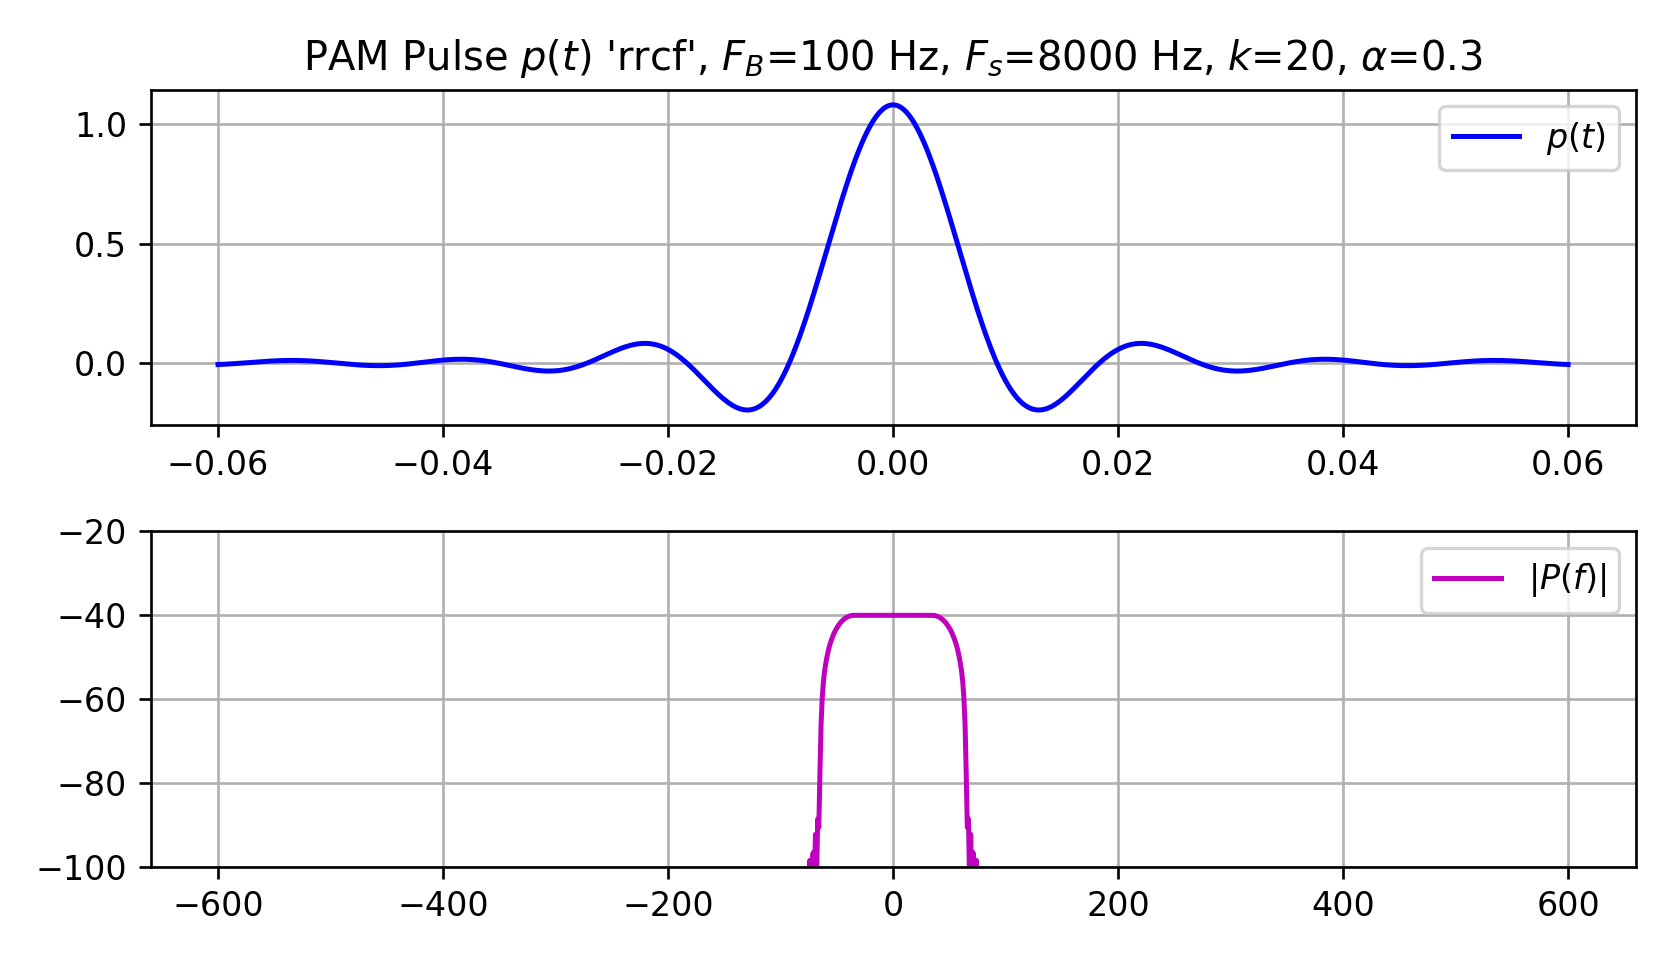

In [13]:
ttpt2 = 6/float(FB); ttpt1 = -ttpt2
ffPf2 = 6*FB; ffPf1 = -ffPf2
ixdttpt = np.where(np.logical_and(ttpt>=ttpt1, ttpt<=ttpt2))
ixdffPf = np.where(np.logical_and(ffPf>=ffPf1, ffPf<=ffPf2))
plt.figure(3, figsize=fsz)
plt.subplot(211)
plt.plot(ttpt[ixdttpt], pt[ixdttpt], '-b', label='$p(t)$')
strt3 = "PAM Pulse $p(t)$ '{}'".format(ptype)
strt3 = strt3 + ', $F_B$={} Hz'.format(FB)
strt3 = strt3 + ', $F_s$={} Hz'.format(Fs)
if ptype == 'sinc':
    strt3 = strt3 + ', $k$={}, $\\beta$={}'.format(*pparms)
if (ptype == 'rcf' or ptype == 'rrcf'):
    strt3 = strt3 + ', $k$={}, $\\alpha$={}'.format(*pparms)
plt.title(strt3)
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(ffPf[ixdffPf], 20*np.log10(np.abs(Pf[ixdffPf])), '-m', label='$|P(f)|$')
plt.ylim([-100, -20])
plt.legend()
plt.grid()
plt.tight_layout()

In [14]:
# Generate PAM signal s(t)
if polar:
    an = 2*dn-(2**m-1)
else:
    an = dn
tt, st = pam15(an, FB, Fs, ptype, pparms) 
Sf = np.fft.fft(st)/float(Fs)
NSf = Sf.size
DSf = Fs/float(NSf)
ff = DSf*np.arange(NSf)-Fs/2.0
Sf = np.fft.fftshift(Sf)

In [15]:
# s(t) sampling times
dlys = 0.0   # sampling delay as fraction of TB
NSs = FB/float(Fs)*np.floor(st.size)
ixss = np.array(np.round(Fs/float(FB)*(0.5+np.arange(NSs)+dlys)),np.int64)
       # sampling times (n+dlys)*TB
ix = np.where(np.logical_and(ixss>=0, ixss<st.size))[0]
ixss = ixss[ix]     # trim ixss values to indexes in s(t)
sn = st[ixss]

<IPython.core.display.Javascript object>


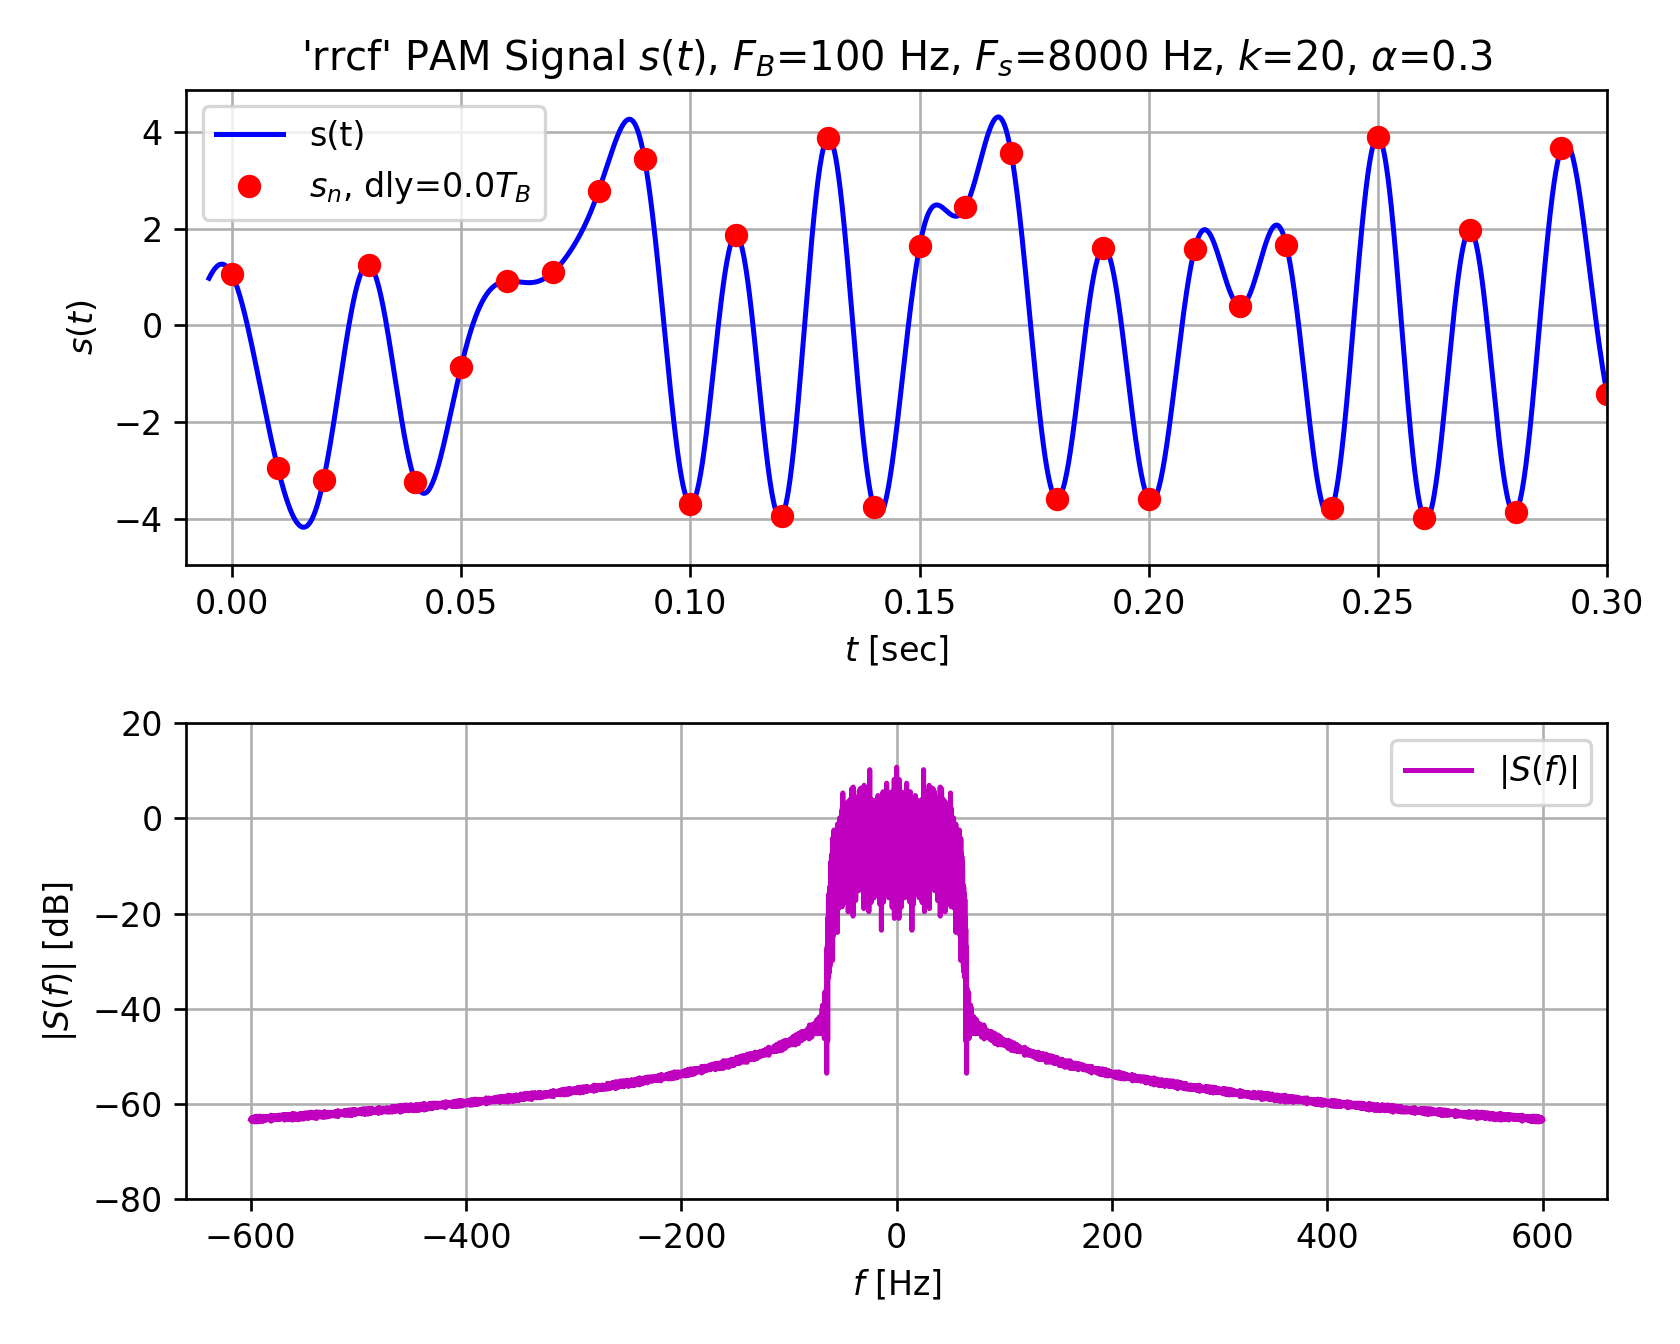

In [16]:
ff2 = 6*FB; ff1 = -ff2
ixdff = np.where(np.logical_and(ff>=ff1, ff<=ff2))
plt.figure(7, figsize=fsz1)
plt.subplot(211)
plt.plot(tt, st, '-b', label='s(t)')
plt.plot(tt[ixss], st[ixss], 'or', label='$s_n$, dly={}$T_B$'.format(dlys))
plt.xlim([-0.01, 0.3])
strt7 = "'{}' PAM Signal $s(t)$".format(ptype)
strt7 = strt7 + ', $F_B$={} Hz'.format(FB)
strt7 = strt7 + ', $F_s$={} Hz'.format(Fs)
if ptype == 'sinc':
    strt7 = strt7 + ', $k$={}, $\\beta$={}'.format(*pparms)
if (ptype == 'rcf' or ptype == 'rrcf'):
    strt7 = strt7 + ', $k$={}, $\\alpha$={}'.format(*pparms)
plt.title(strt7)
plt.ylabel('$s(t)$')
plt.xlabel('$t$ [sec]')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(ff[ixdff], 20*np.log10(np.abs(Sf[ixdff])), '-m', label='$|S(f)|$')
plt.ylim([-80, 20])
plt.ylabel('$|S(f)|$ [dB]')
plt.xlabel('$f$ [Hz]')
plt.legend()
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


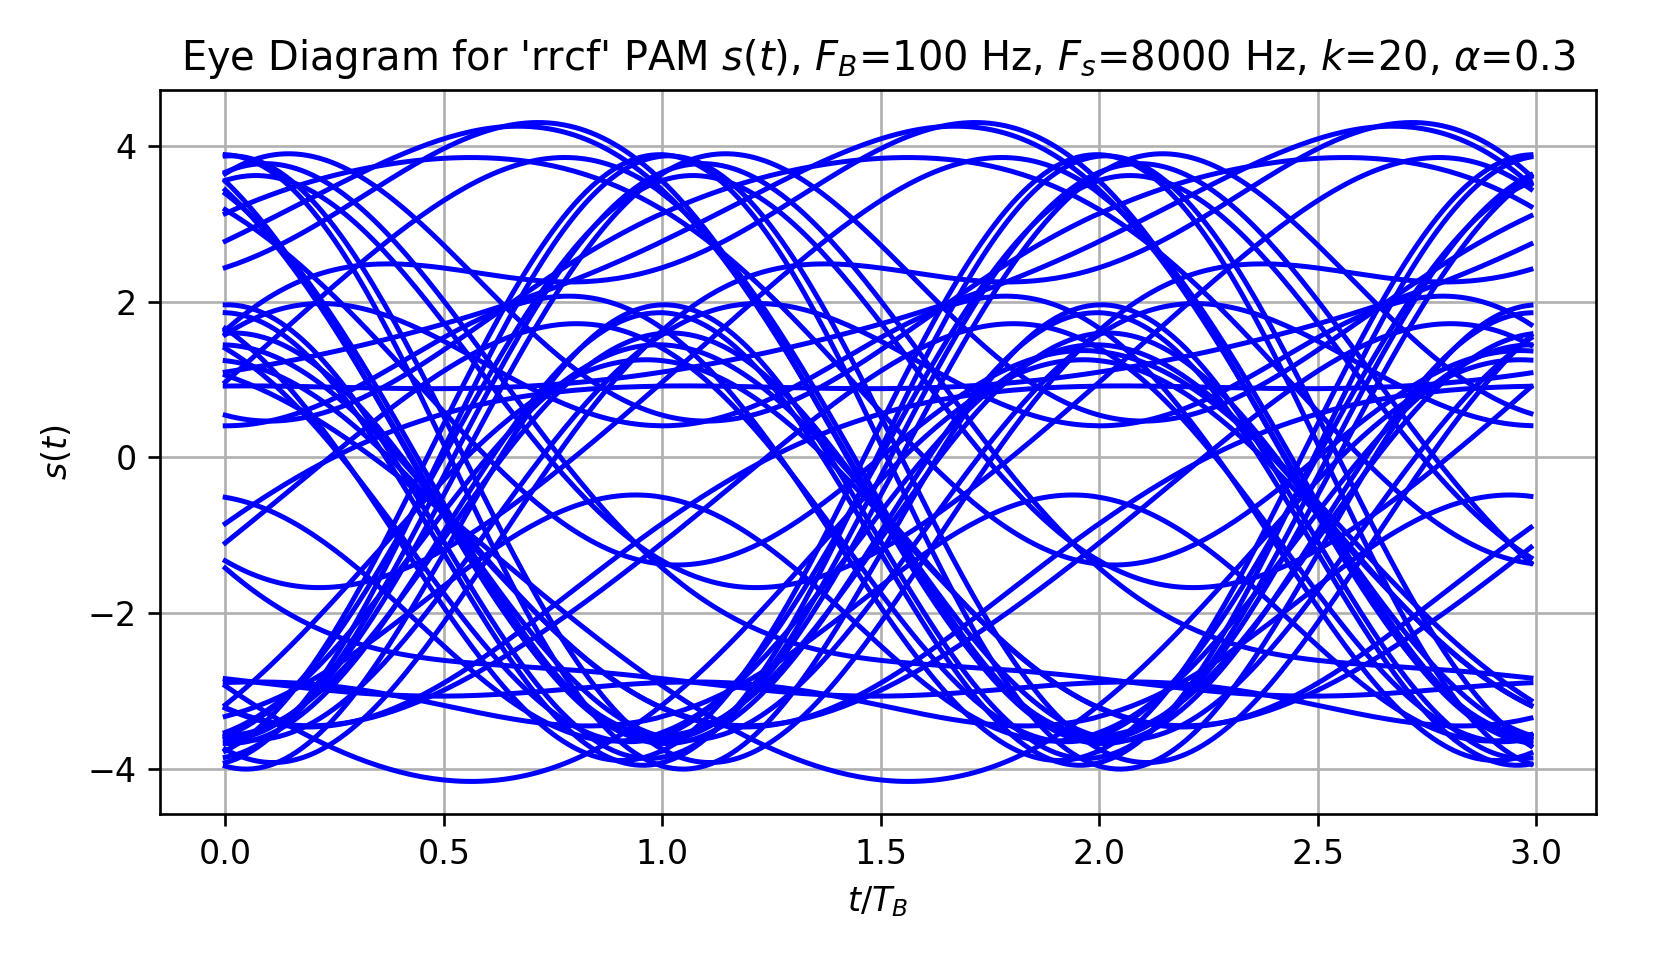

In [17]:
ttAs, As = eyediagram(tt, st, FB)
plt.figure(11, figsize=fsz)
plt.plot(ttAs, As[0], '-b')
for i in range(1,As.shape[0]):
    plt.plot(ttAs, As[i], '-b')
strt11 = "Eye Diagram for '{}' PAM $s(t)$".format(ptype)
strt11 = strt11 + ', $F_B$={} Hz'.format(FB)
strt11 = strt11 + ', $F_s$={} Hz'.format(Fs)
if ptype == 'sinc':
    strt11 = strt11 + ', $k$={}, $\\beta$={}'.format(*pparms)
if (ptype == 'rcf' or ptype == 'rrcf'):
    strt11 = strt11 + ', $k$={}, $\\alpha$={}'.format(*pparms)
plt.title(strt11)
plt.ylabel('$s(t)$')
plt.xlabel('$t/T_B$')    
plt.grid()
plt.tight_layout()

In [18]:
# Generate Gaussian noise
nt = np.random.randn(st.size)
P_nt = np.mean(np.power(nt, 2.0))  # randn noise power
SNR = 10**(SNRdB/10.0)
Ps = np.mean(np.power(st, 2.0))
An = np.sqrt(Ps/(SNR*P_nt))
P_Ant = np.mean(np.power(An*nt, 2.0))
print('Ps={:4.3f}, Pn={:5.4f}'.format(Ps, P_Ant))

Ps=4.196, Pn=1.0539


In [19]:
# Received signal
rt = st + An*nt
Rf = np.fft.fft(rt)/float(Fs)
Rf = np.fft.fftshift(Rf)

In [20]:
# r(t) sampling times
dlyr = 0.0   # sampling delay as fraction of TB
NSr = FB/float(Fs)*np.floor(rt.size)
ixsr = np.array(np.round(Fs/float(FB)*(0.5+np.arange(NSr)+dlyr)),np.int64)
       # sampling times (n+dlyr)*TB
ix = np.where(np.logical_and(ixsr>=0, ixsr<rt.size))[0]
ixsr = ixsr[ix]     # trim ixss values to indexes in s(t)
rn = rt[ixsr]

<IPython.core.display.Javascript object>


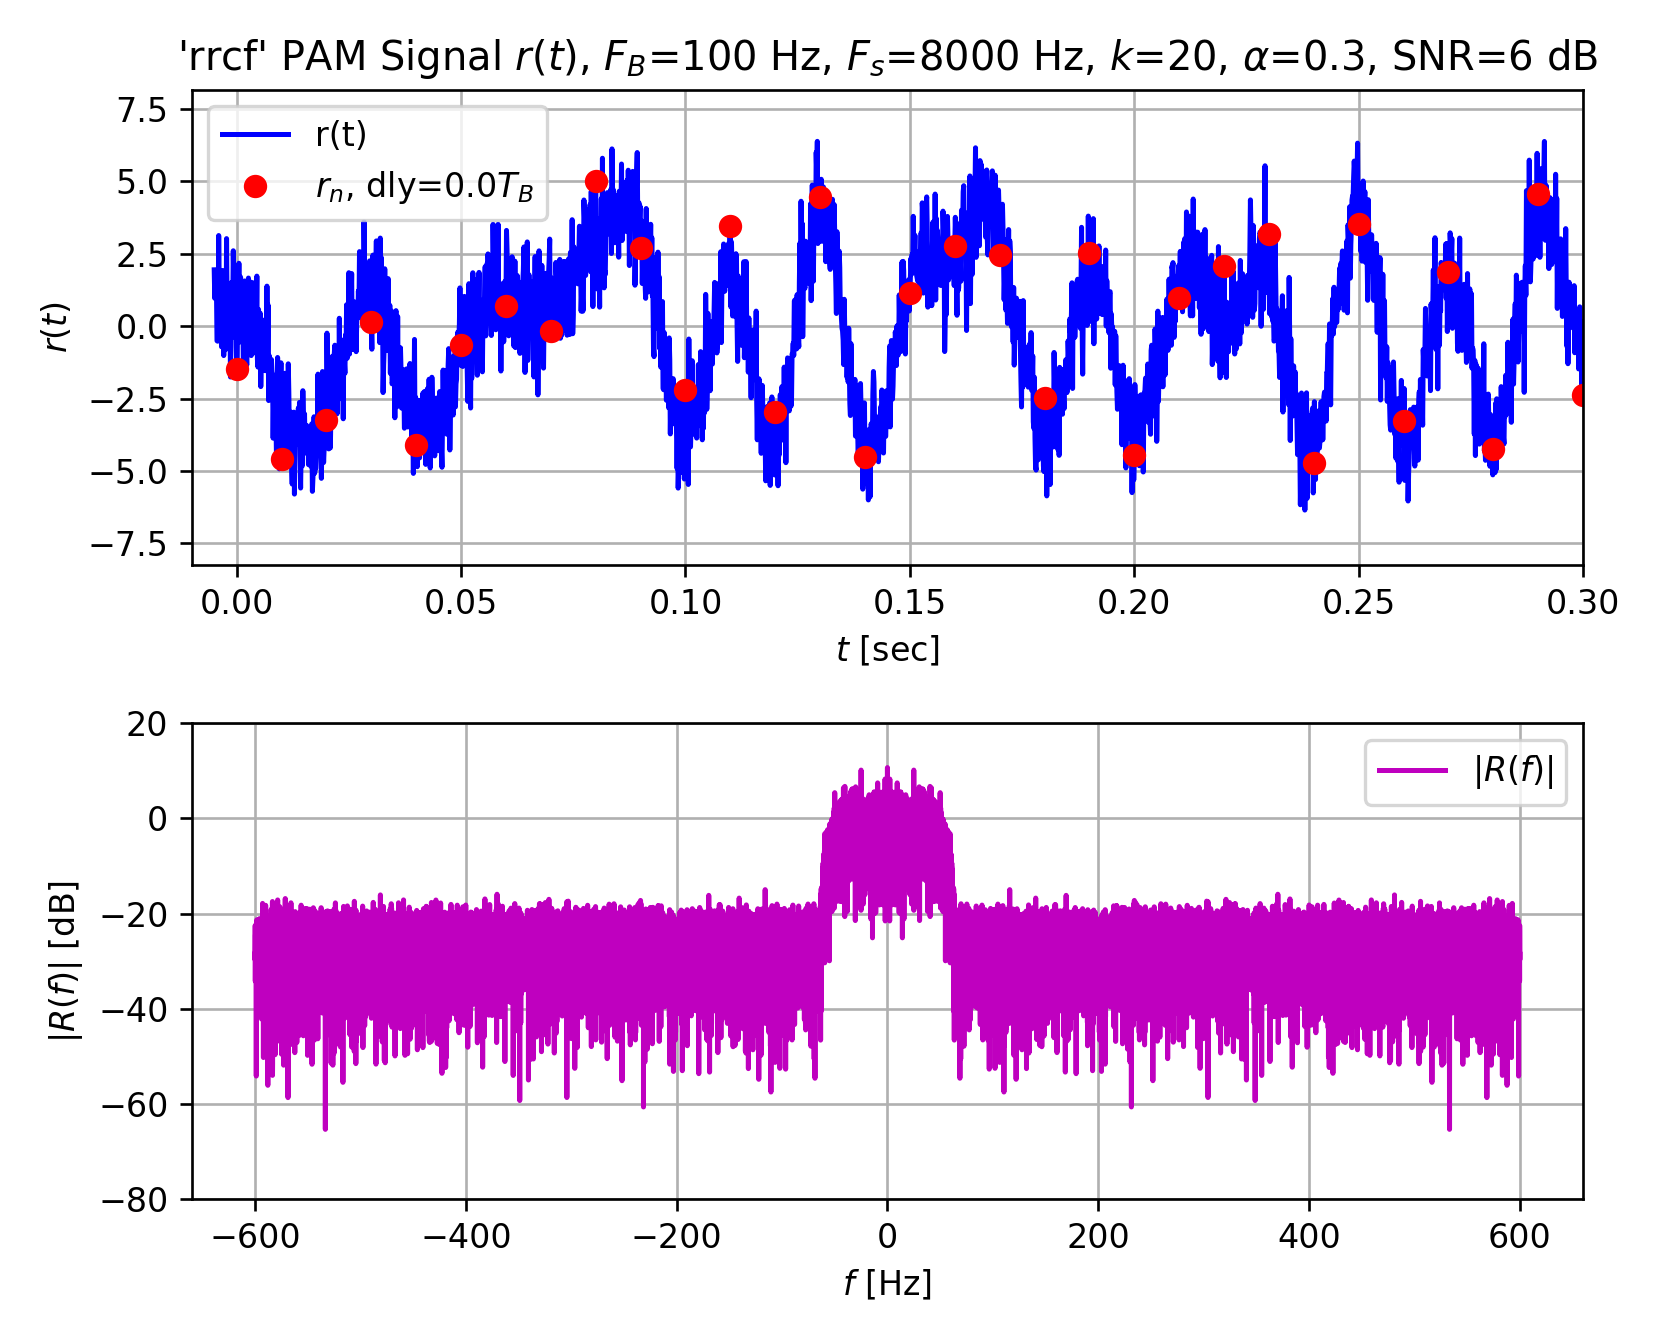

In [21]:
plt.figure(15, figsize=fsz1)
plt.subplot(211)
plt.plot(tt, rt, '-b', label='r(t)')
plt.plot(tt[ixsr], rt[ixsr], 'or', label='$r_n$, dly={}$T_B$'.format(dlyr))
plt.xlim([-0.01, 0.3])
strt15 = "'{}' PAM Signal $r(t)$".format(ptype)
strt15 = strt15 + ', $F_B$={} Hz'.format(FB)
strt15 = strt15 + ', $F_s$={} Hz'.format(Fs)
if ptype == 'sinc':
    strt15 = strt15 + ', $k$={}, $\\beta$={}'.format(*pparms)
if (ptype == 'rcf' or ptype == 'rrcf'):
    strt15 = strt15 + ', $k$={}, $\\alpha$={}'.format(*pparms)
strt15 = strt15 + ', SNR={} dB'.format(SNRdB)
plt.title(strt15)
plt.ylabel('$r(t)$')
plt.xlabel('$t$ [sec]')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(ff[ixdff], 20*np.log10(np.abs(Rf[ixdff])), '-m', label='$|R(f)|$')
plt.ylim([-80, 20])
plt.ylabel('$|R(f)|$ [dB]')
plt.xlabel('$f$ [Hz]')
plt.legend()
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


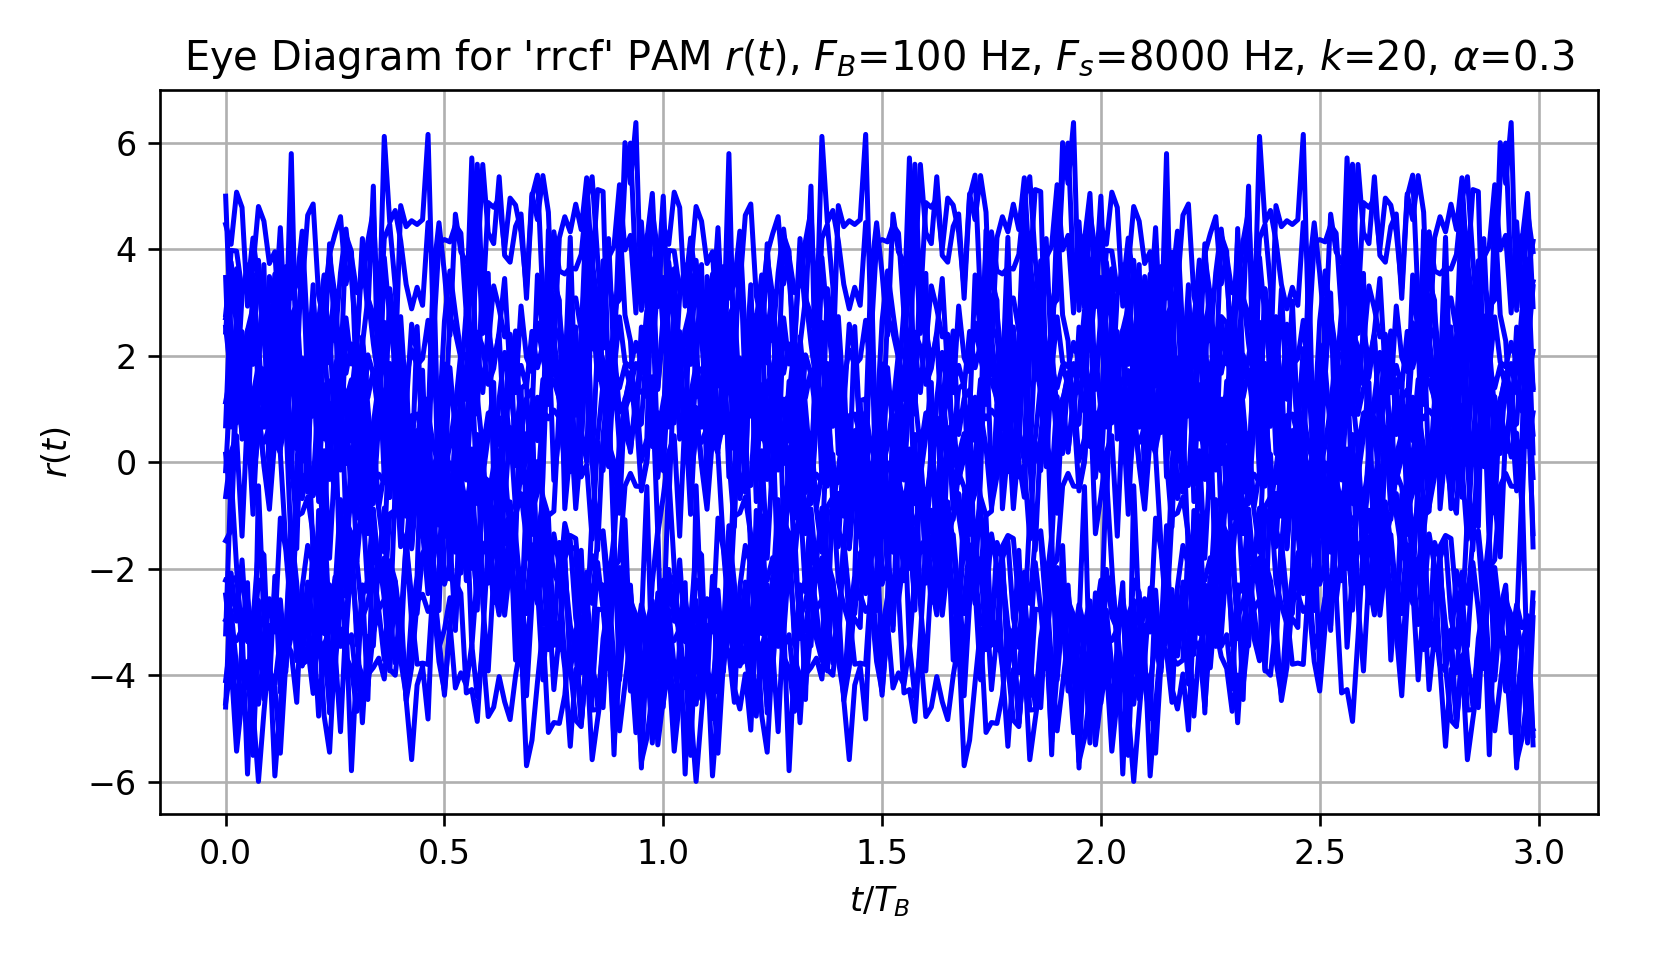

In [22]:
ttAr, Ar = eyediagram(tt, rt, FB, 20)
plt.figure(19, figsize=fsz)
plt.plot(ttAr, Ar[0], '-b')
for i in range(1,Ar.shape[0]):
    plt.plot(ttAr, Ar[i], '-b')
strt19 = "Eye Diagram for '{}' PAM $r(t)$".format(ptype)
strt19 = strt19 + ', $F_B$={} Hz'.format(FB)
strt19 = strt19 + ', $F_s$={} Hz'.format(Fs)
if ptype == 'sinc':
    strt19 = strt19 + ', $k$={}, $\\beta$={}'.format(*pparms)
if (ptype == 'rcf' or ptype == 'rrcf'):
    strt19 = strt19 + ', $k$={}, $\\alpha$={}'.format(*pparms)
plt.title(strt19)
plt.ylabel('$r(t)$')
plt.xlabel('$t/T_B$')    
plt.grid()
plt.tight_layout()

In [23]:
# Demodulated signal
dlyb = 0.0    # sampling delay as fraction of TB
bn, bt, ixn = pamrcvr15(tt, rt, [FB, dlyb], ptype, pparms)
Bf = np.fft.fft(bt)/float(Fs)
Bf = np.fft.fftshift(Bf)

<IPython.core.display.Javascript object>


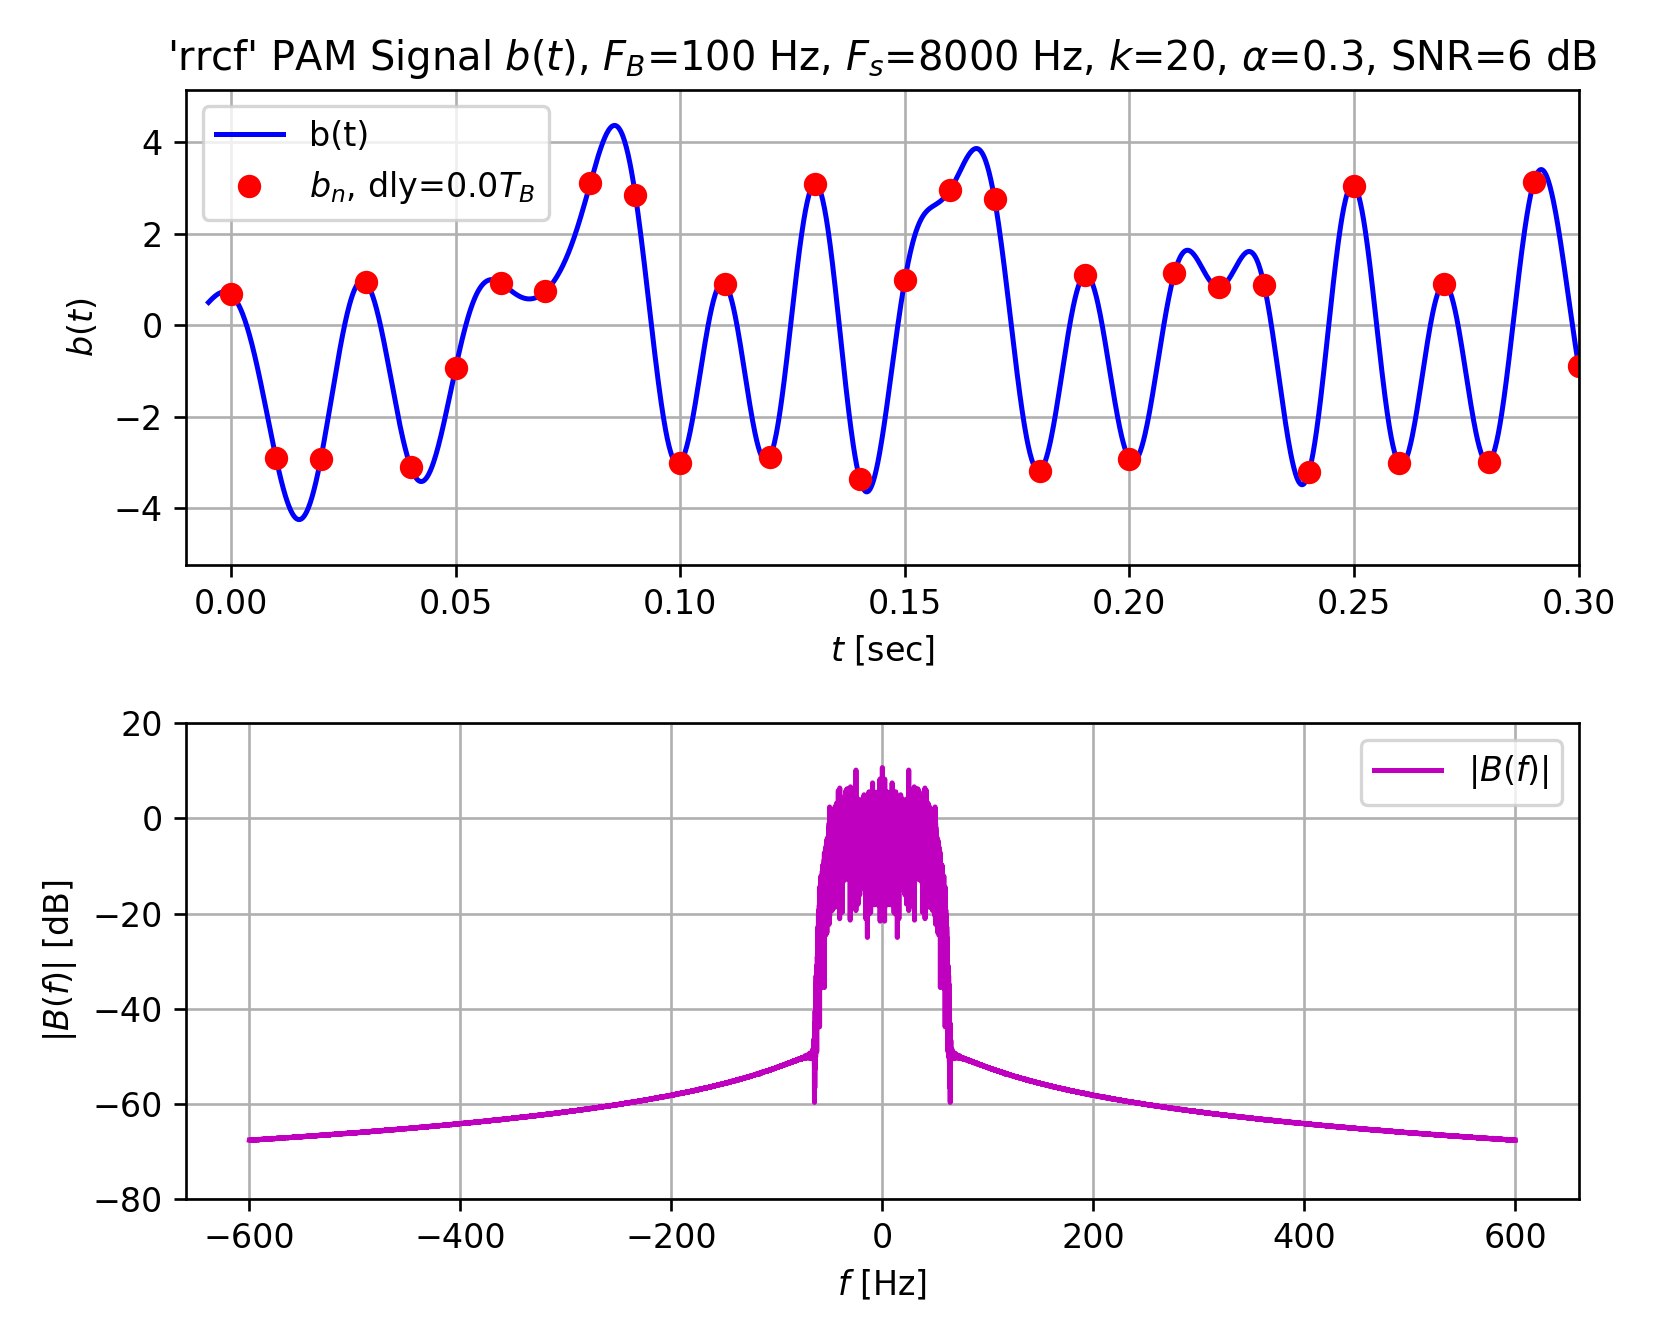

In [24]:
plt.figure(23, figsize=fsz1)
plt.subplot(211)
plt.plot(tt, bt, '-b', label='b(t)')
plt.plot(tt[ixn], bt[ixn], 'or', label='$b_n$, dly={}$T_B$'.format(dlyb))
plt.xlim([-0.01, 0.3])
strt23 = "'{}' PAM Signal $b(t)$".format(ptype)
strt23 = strt23 + ', $F_B$={} Hz'.format(FB)
strt23 = strt23 + ', $F_s$={} Hz'.format(Fs)
if ptype == 'sinc':
    strt23 = strt23 + ', $k$={}, $\\beta$={}'.format(*pparms)
if (ptype == 'rcf' or ptype == 'rrcf'):
    strt23 = strt23 + ', $k$={}, $\\alpha$={}'.format(*pparms)
strt23 = strt23 + ', SNR={} dB'.format(SNRdB)
plt.title(strt23)
plt.ylabel('$b(t)$')
plt.xlabel('$t$ [sec]')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(ff[ixdff], 20*np.log10(np.abs(Bf[ixdff])), '-m', label='$|B(f)|$')
plt.ylim([-80, 20])
plt.ylabel('$|B(f)|$ [dB]')
plt.xlabel('$f$ [Hz]')
plt.legend()
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


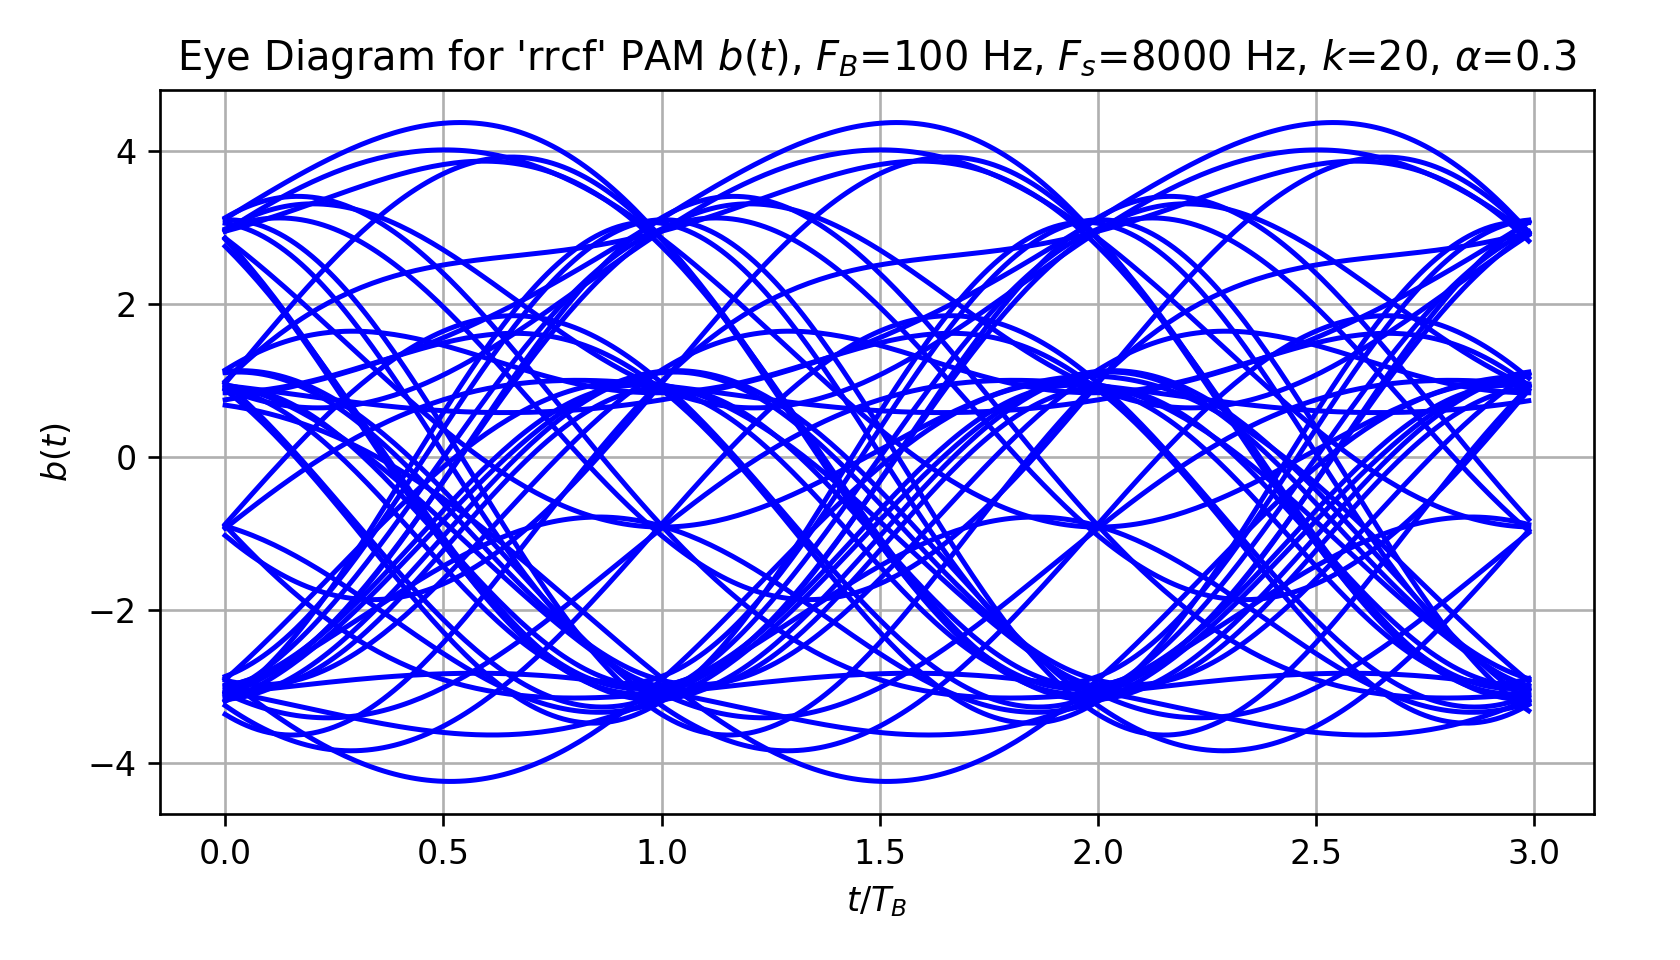

In [25]:
ttAb, Ab = eyediagram(tt, bt, FB)
plt.figure(27, figsize=fsz)
plt.plot(ttAb, Ab[0], '-b')
for i in range(1,Ab.shape[0]):
    plt.plot(ttAb, Ab[i], '-b')
strt27 = "Eye Diagram for '{}' PAM $b(t)$".format(ptype)
strt27 = strt27 + ', $F_B$={} Hz'.format(FB)
strt27 = strt27 + ', $F_s$={} Hz'.format(Fs)
if ptype == 'sinc':
    strt27 = strt27 + ', $k$={}, $\\beta$={}'.format(*pparms)
if (ptype == 'rcf' or ptype == 'rrcf'):
    strt27 = strt27 + ', $k$={}, $\\alpha$={}'.format(*pparms)
plt.title(strt27)
plt.ylabel('$b(t)$')
plt.xlabel('$t/T_B$')    
plt.grid()
plt.tight_layout()

In [26]:
# Recover received text
an_hat = bn
if polar:
    sn_hat = (an_hat + (2**m-1))/2.0
sn_hat = np.array(np.round(sn_hat), int)   # convert to integers
dn_hat = M2b(sn_hat, m)
txt_hat = bin2asc(dn_hat, bits)
print('Received txt:\n{}'.format(txt_hat))

Received txt:
AXOLOTL, also known as the Mexican Walking Fish,
this amphibious salamander is critically endangered,
and nearly went extinct in 2010.
Although the axolotl is colloquially known as a "walking fish",
it is not a fish, but an amphibian. The species was originally found
in several lakes, such as Lake Xochimilco underlying Mexico City.
Axolotls are unusual among amphibians in that they reach adulthood
without undergoing metamorphosis. Instead of developing lungs and
taking to the land, adults remain aquatic and gilled.


<img src="Axolotl.jpg" alt="Axolotl also known as Mexican Walking Fish" />